In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys, os
root = os.path.join(os.getcwd(), '../../')
sys.path.append(root)

import numpy as np


In [2]:
from gpt.element import Lattice, Screen
from gpt.bstatic import Sectormagnet
from gpt.maps import Map2D_E, Map2D_B

c = 299792458
MC2 = 0.51099895000e6

In [3]:
lat = Lattice('Gun Test')

g = 1 + 500e3/MC2
p = MC2*np.sqrt(g**2-1)

GUN_FILE = os.path.join(root,'templates/dcgun/fields/gun_0mm.gdf');
SOL_FILE = os.path.join(root,'templates/dcgun/fields/solenoid_SLA_L60_1D.gdf');

lat.add(Map2D_E('dcgun', 'fields/gun_0mm.gdf'), ds=0.0)
lat.add(Map2D_B('sol1', 'fields/solenoid_SLA_L60.gdf'), ds=1)
lat.add(Sectormagnet('b1', 1.0, +90, p, phi_in=45, phi_out=45, color='b', fix=True), ds=1)
lat.add(Map2D_B('sol2', 'fields/solenoid_SLA_L60.gdf'), ds=1)

print(lat)

Lattice: Gun Test
s-start: 0 m.
s-stop: 5.920796326794896

Name: beg
Type: lattice starting element
s-entrance: 0 m.
s-exit: 0 m.
Length: 0
Width: 0 m.

Name: dcgun
Type: Map2D_E
s-entrance: 0.0 m.
s-exit: 0.15 m.
Length: 0.15
Width: 0.2 m.

Name: sol1
Type: Map2D_B
s-entrance: 1.15 m.
s-exit: 1.75 m.
Length: 0.6
Width: 0.2 m.

Name: b1
Type: Sectormagnet
s-entrance: 2.75 m.
s-exit: 4.320796326794897 m.
Length: 1.5707963267948966
Width: 0.2 m.
Radius: 1.0 m.
phi_in: 45 deg.
phi_out: 45 deg.
CCS into dipole: "wcs"

Name: sol2
Type: Map2D_B
s-entrance: 5.320796326794897 m.
s-exit: 5.920796326794896 m.
Length: 0.6
Width: 0.2 m.


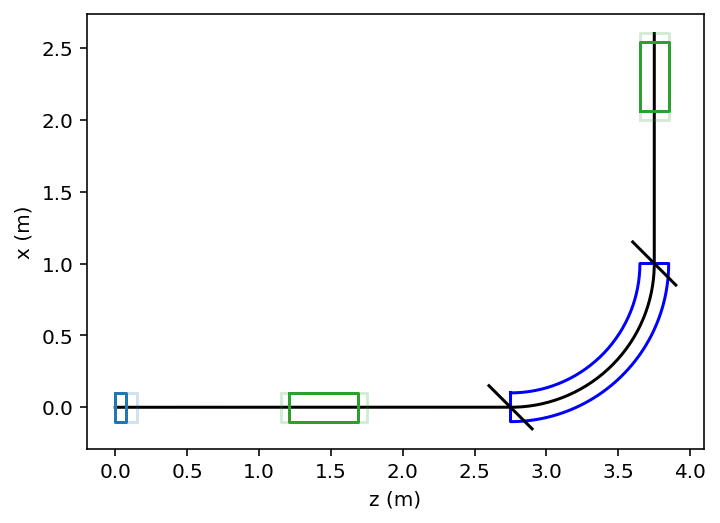

In [4]:
lat.plot_floor();

In [5]:
from gpt import GPT
from distgen import Generator

DISTGEN_INPUT_FILE = os.path.join(root,'templates/dcgun_distgen/distgen.in.yaml')

lat.write_gpt_lines(output_file='gpt.temp.in');

gen = Generator(DISTGEN_INPUT_FILE, verbose=0)
gen['n_particle']=100
gen['t_dist:sigma_t:units']='ps'
gen.run()

settings={
    'cathode' : 1.0, 
    'Ntout':500, 
    'space_charge':0, 
    'tmax':1.3*lat[-1].s_end/c,
    'sol1_scale':5,
    'sol2_scale':5,
    'ZSTOP':5
}

G = GPT(input_file='gpt.temp.in', initial_particles=gen.particles)
G.set_variables(settings)
G.run()
print(G)


GPT object:
   Original input file: gpt.temp.in
   Template location: /Users/colwyngulliford/Documents/GitHub/lume-gpt/examples/elements
   Use temp directory: True

Run Control
   Run configured: True
   Work location: /var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpzocrxzqd
   Timeout: None (sec)

Results
   Finished: True
   Error occured: False
   Run time: 0.5168027877807617 (sec)


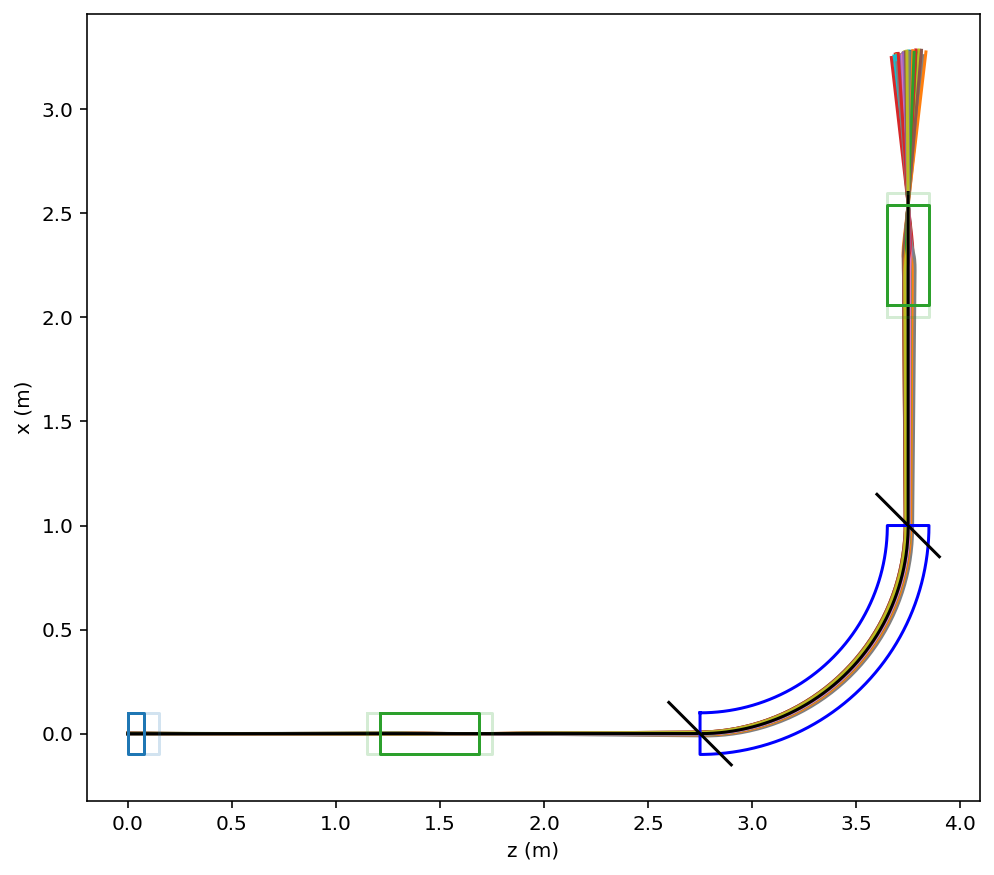

In [6]:
plt.figure(figsize=(8,8))
for ii in range(0, gen['n_particle']):
    tii = G.trajectory(ii, data_type='tout')
    if(tii is not None and ii%1==0):
        plt.plot(tii['z'], tii['x'])
lat.plot_floor();

In [7]:
os.remove('gpt.temp.in')